# Task 2: Vehicle Damage Classification using Custom CNN and OpenCV

### Objective
#### Build a multiclass image classification system to classify car images as:
- damaged (scratches, dents, etc.)

- whole (undamaged cars)

Using:

- PyTorch (custom CNN)

- OpenCV for preprocessing

- Grad-CAM for interpretability

- Evaluation metrics (accuracy, F1-score, confusion matrix)

- Inference pipeline for real-world use

In [1]:
!pip install -q kaggle opencv-python-headless

In [2]:
import os
from google.colab import files

# Upload kaggle.json
files.upload()

# Move it into place
os.makedirs("/root/.kaggle", exist_ok=True)
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


Dataset Overview
The dataset is downloaded from Kaggle: Car Damage Detection

It includes:

00-damage: Images of damaged cars

01-whole: Images of undamaged cars

In [3]:
!kaggle datasets download -d anujms/car-damage-detection
!unzip -q car-damage-detection.zip -d data_raw

Dataset URL: https://www.kaggle.com/datasets/anujms/car-damage-detection
License(s): unknown
 76% 93.0M/123M [00:00<00:00, 968MB/s]
100% 123M/123M [00:00<00:00, 849MB/s] 


 ### Dataset Preparation
We restructured the dataset into ImageFolder format compatible with PyTorch.

In [4]:
import os
import shutil

# Paths
source_root = "data_raw/data1a"
target_root = "data"

# Mapping of old folder names to new class names
folder_map = {
    "00-damage": "damaged",
    "01-whole": "whole"
}

# Process both training and validation
for split in ['training', 'validation']:
    split_target = 'train' if split == 'training' else 'val'
    for old_folder, new_folder in folder_map.items():
        src = os.path.join(source_root, split, old_folder)
        dst = os.path.join(target_root, split_target, new_folder)
        os.makedirs(dst, exist_ok=True)

        for file in os.listdir(src):
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                shutil.copy(os.path.join(src, file), os.path.join(dst, file))

print("Dataset successfully organized!")


Dataset successfully organized!


### OpenCV-Based Preprocessing
We used OpenCV for preprocessing images before feeding them into the model.

Steps:

- Load image using cv2.imread

- Resize to 224×224

- Apply CLAHE for contrast enhancement

- Normalize and convert to PyTorch Tensor

In [5]:
import cv2
import numpy as np
import torch
from torchvision.transforms import ToTensor

class OpenCVTransform:
    def __init__(self, size=(224, 224)):
        self.size = size
        self.to_tensor = ToTensor()

    def __call__(self, path):
        # Read with OpenCV
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize
        image = cv2.resize(image, self.size)

        # Apply CLAHE (contrast enhancement)
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l)
        limg = cv2.merge((cl, a, b))
        image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

        # Normalize to [0, 1]
        tensor = self.to_tensor(image)  # Converts HWC → CHW and scales to [0, 1]
        return tensor


### Data Loading with PyTorch
We use torchvision.datasets.ImageFolder wrapped in a custom class that uses the OpenCV transform.

In [6]:
from torchvision.datasets import ImageFolder

class OpenCVImageFolder(ImageFolder):
    def __init__(self, root, transform):
        super().__init__(root, loader=transform, transform=None)


### Load the dataset using DataLoader
Fix the Train and Val dataset

In [7]:
from torch.utils.data import DataLoader

# Define the transform
opencv_transform = OpenCVTransform(size=(224, 224))

# Load datasets
train_dataset = OpenCVImageFolder("data/train", transform=opencv_transform)
val_dataset = OpenCVImageFolder("data/val", transform=opencv_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Print class labels
print("Classes:", train_dataset.classes)

Classes: ['damaged', 'whole']


### CNN Model Architecture (from scratch)
We define a 3-block CNN with BatchNorm, ReLU, MaxPooling, Dropout, and 2 Fully Connected layers.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CarDamageCNN(nn.Module):
    def __init__(self, num_classes):
        super(CarDamageCNN, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Input: RGB image (3 channels)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        x = x.view(x.size(0), -1)  # flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [9]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CarDamageCNN(num_classes=2).to(device)


In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Optional scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [11]:
import torch
import torch.nn.functional as F
import time
from tqdm import tqdm
import os

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total = 0

    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Stats
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels)
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct_preds.double() / total
    return epoch_loss, epoch_acc.item()


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels)
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct_preds.double() / total
    return epoch_loss, epoch_acc.item()


### Training Loop with Validation, Checkpointing & Early Stopping
- Logs loss and accuracy per epoch

- Saves best model based on validation accuracy

- Stops early if performance degrades

In [12]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, device, num_epochs=10, save_path='best_model.pth', early_stop_patience=5):
    best_val_acc = 0.0
    best_model_state = None
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    early_stop_counter = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        scheduler.step()

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            torch.save(best_model_state, save_path)
            print("Model saved.")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stop_patience:
                print("Early stopping triggered.")
                break

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    model.load_state_dict(torch.load(save_path))

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.legend()
    plt.title("Accuracy")

    plt.tight_layout()
    plt.show()

    return model



Epoch 1/20


Train Loss: 13.4798 | Train Acc: 0.6103
Val   Loss: 0.5154 | Val   Acc: 0.7348
Model saved.

Epoch 2/20


Train Loss: 0.6302 | Train Acc: 0.6978
Val   Loss: 0.5601 | Val   Acc: 0.7174

Epoch 3/20


Train Loss: 0.5065 | Train Acc: 0.7609
Val   Loss: 0.5175 | Val   Acc: 0.7522
Model saved.

Epoch 4/20


Train Loss: 0.4823 | Train Acc: 0.7761
Val   Loss: 0.4885 | Val   Acc: 0.7826
Model saved.

Epoch 5/20


Train Loss: 0.4526 | Train Acc: 0.7908
Val   Loss: 0.4978 | Val   Acc: 0.7717

Epoch 6/20


Train Loss: 0.4077 | Train Acc: 0.8125
Val   Loss: 0.4732 | Val   Acc: 0.7891
Model saved.

Epoch 7/20


Train Loss: 0.3977 | Train Acc: 0.8163
Val   Loss: 0.4641 | Val   Acc: 0.7913
Model saved.

Epoch 8/20


Train Loss: 0.3785 | Train Acc: 0.8288
Val   Loss: 0.4555 | Val   Acc: 0.8022
Model saved.

Epoch 9/20


Train Loss: 0.3668 | Train Acc: 0.8380
Val   Loss: 0.4487 | Val   Acc: 0.8022

Epoch 10/20


Train Loss: 0.3551 | Train Acc: 0.8408
Val   Loss: 0.4448 | Val   Acc: 0.8130
Model saved.

Epoch 11/20


Train Loss: 0.3516 | Train Acc: 0.8576
Val   Loss: 0.4406 | Val   Acc: 0.8152
Model saved.

Epoch 12/20


Train Loss: 0.3386 | Train Acc: 0.8554
Val   Loss: 0.4413 | Val   Acc: 0.8152

Epoch 13/20


Train Loss: 0.3519 | Train Acc: 0.8424
Val   Loss: 0.4428 | Val   Acc: 0.8174
Model saved.

Epoch 14/20


Train Loss: 0.3492 | Train Acc: 0.8516
Val   Loss: 0.4407 | Val   Acc: 0.8152

Epoch 15/20


Train Loss: 0.3480 | Train Acc: 0.8565
Val   Loss: 0.4408 | Val   Acc: 0.8152

Epoch 16/20


Train Loss: 0.3424 | Train Acc: 0.8538
Val   Loss: 0.4397 | Val   Acc: 0.8130
Early stopping triggered.


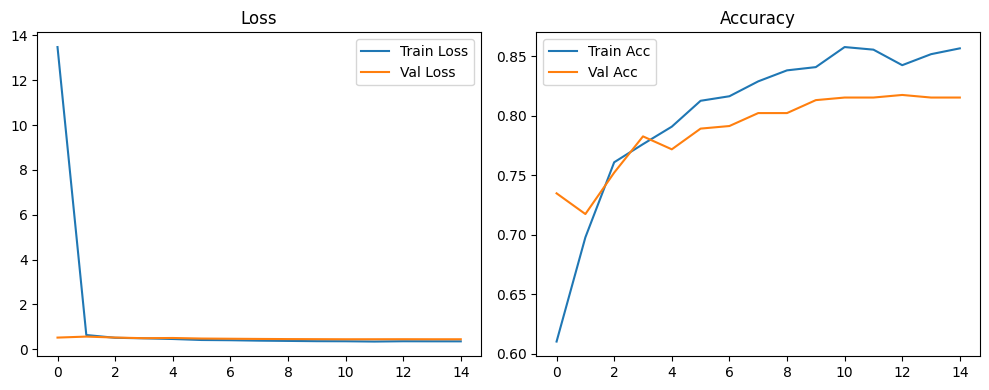

In [13]:
trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    device=device,
    num_epochs=20,
    save_path='best_car_damage_model.pth',
    early_stop_patience=3
)


### Evaluation: Classification Report + Confusion Matrix
We evaluate the trained model using:

- Accuracy

- Precision, Recall, F1-score

- Confusion Matrix (visualized using Seaborn)

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

In [15]:
def evaluate_model(model, dataloader, class_names, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Classification report
    print("📊 Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


📊 Classification Report:

              precision    recall  f1-score   support

     damaged       0.80      0.85      0.82       230
       whole       0.84      0.78      0.81       230

    accuracy                           0.82       460
   macro avg       0.82      0.82      0.82       460
weighted avg       0.82      0.82      0.82       460



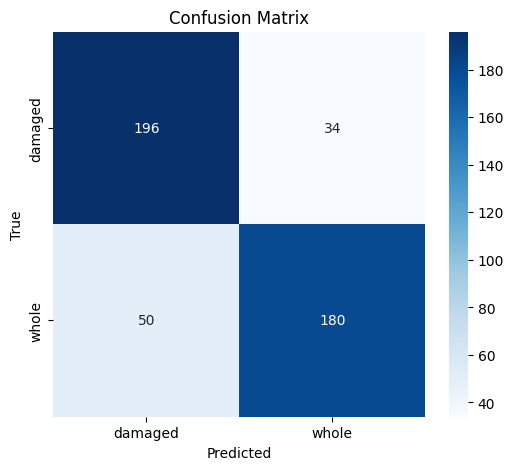

In [16]:
class_names = train_dataset.classes
evaluate_model(trained_model, val_loader, class_names, device)

In [17]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.8 MB/s e

### Grad-CAM Visualization (Model Interpretability)
Grad-CAM highlights where the model is looking when making predictions.

Steps:

- Get last convolutional layer

- Generate Grad-CAM heatmap

- Overlay it on the input image

In [18]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.image import preprocess_image

def apply_gradcam(model, image_tensor, target_category, device):
    model.eval()
    target_layer = model.conv_block3[0]  # Choose last Conv2D layer

    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=image_tensor.unsqueeze(0), targets=[ClassifierOutputTarget(target_category)])

    grayscale_cam = grayscale_cam[0, :]
    input_image = image_tensor.permute(1, 2, 0).cpu().numpy()
    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())

    visualization = show_cam_on_image(input_image, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(6, 6))
    plt.imshow(visualization)
    plt.title(f"Grad-CAM for Class: {class_names[target_category]}")
    plt.axis('off')
    plt.show()


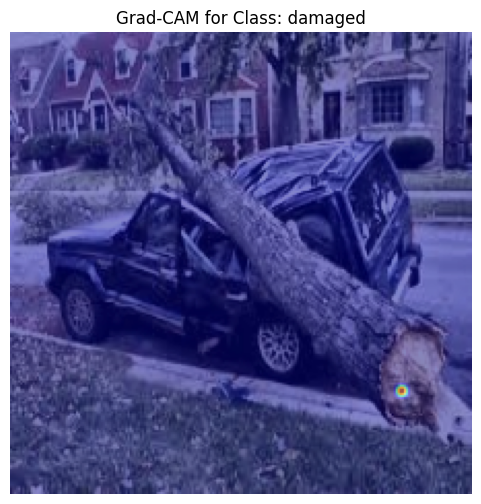

In [19]:
image, label = val_dataset[0]
apply_gradcam(trained_model, image.to(device), target_category=label, device=device)

### Inference on a Single Image
We allow real-world inference using one image path and return the predicted label.

In [20]:
def predict_single_image(model, image_path, transform, class_names, device):
    model.eval()
    with torch.no_grad():
        img = transform(image_path).unsqueeze(0).to(device)
        outputs = model(img)
        _, pred = torch.max(outputs, 1)
        predicted_class = class_names[pred.item()]
        return predicted_class

In [22]:
prediction = predict_single_image(
    model=trained_model,
    image_path="/content/data/val/damaged/0001.JPEG",
    transform=OpenCVTransform(),
    class_names=train_dataset.classes,
    device=device
)
print("Prediction:", prediction)


Prediction: damaged


## Conclusion
- Built a custom CNN using PyTorch for damage detection.

- Preprocessed data with OpenCV using real-world techniques (CLAHE, resize).

- Trained and evaluated the model with accuracy and confusion matrix.

- Added Grad-CAM to interpret which regions influence predictions.

- Built a real-time inference function for single image prediction.